### Probablistic LSTM Modal

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
data = pd.read_csv("./data_saved/EURUSD_M1_2023.csv")

print(data.head(10))
print(data.describe())

# # Normalize data
# data_norm = data.copy()
# data_norm[['open', 'high', 'low', 'close']] = (data[['open', 'high', 'low', 'close']] - data[['open', 'high', 'low', 'close']].mean()) / data[['open', 'high', 'low', 'close']].std()


# data_norm.head(10)

             timestamp     open     high      low    close
0  2023-01-01 17:05:00  1.06973  1.06978  1.06970  1.06970
1  2023-01-01 17:06:00  1.06966  1.06966  1.06966  1.06966
2  2023-01-01 17:08:00  1.06970  1.06974  1.06970  1.06970
3  2023-01-01 17:10:00  1.06975  1.06980  1.06972  1.06972
4  2023-01-01 17:11:00  1.06972  1.06972  1.06972  1.06972
5  2023-01-01 17:12:00  1.06975  1.06980  1.06975  1.06975
6  2023-01-01 17:13:00  1.07066  1.07066  1.06917  1.06917
7  2023-01-01 17:14:00  1.06937  1.06937  1.06899  1.06899
8  2023-01-01 17:15:00  1.06788  1.06788  1.06788  1.06788
9  2023-01-01 17:16:00  1.06788  1.06788  1.06788  1.06788
                open           high            low          close
count  322637.000000  322637.000000  322637.000000  322637.000000
mean        1.080758       1.080831       1.080684       1.080684
std         0.016279       0.016277       0.016282       0.016282
min         1.044930       1.044980       1.044830       1.044830
25%         1.068360 

In [9]:
# Convert DataFrame to PyTorch tensor and move to GPU
data_tensor = torch.tensor(data[['close']].values, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

data_tensor = data_tensor[:10000]

In [10]:
# Define LSTM model for probabilistic forecasting
class LSTMProbabilistic(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMProbabilistic, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Taking the output from the last time step
        out = self.softmax(out)  # Apply softmax activation to obtain probabilities
        return out


In [19]:
# Parameters
input_size = 1  # Number of features (only 'close' price)
hidden_size = 10  # Number of LSTM units
num_layers = 2  # Number of LSTM layers
output_size = 2  # Output size for binary classification (up or down)
sequence_length = 15  # Number of bars to consider for prediction

# Instantiate the model and move to GPU
model = LSTMProbabilistic(input_size, hidden_size, num_layers, output_size).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Prepare data with sequence length
data_sequences = []
for i in range(len(data) - sequence_length):
    data_sequences.append(data_tensor[:, i:i+sequence_length, :])
data_sequences_tensor = torch.cat(data_sequences, dim=0)


# Training loop
num_epochs = 100
losses = []
predictions = pd.DataFrame()  # DataFrame to store all predictions

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(data_sequences_tensor)
    
    # Prepare target labels (0 for down, 1 for up)
    target_labels = torch.zeros_like(data_sequences_tensor[:, -1, :])  # Initialize with zeros
    target_labels[data_sequences_tensor[:, -1, :] > data_sequences_tensor[:, -2, :]] = 1  # Set to 1 where price goes up
    
    # Flatten the target_labels tensor
    target_labels = target_labels.view(-1)
    
    # Flatten the outputs tensor
    outputs = outputs.view(-1, output_size)
    
    loss = criterion(outputs, target_labels.long())  # Cross entropy loss
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())  # Store the loss value for visualization
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        
        # Calculate actual probabilities (up, down)
        probs = model(data_sequences_tensor)
        
        # Extract close price, target label, and predicted probabilities
        close_prices = data_sequences_tensor[:, -1, :].squeeze().cpu().detach().numpy()
        target_labels = target_labels.cpu().numpy()
        predicted_probs = probs[:, 1].cpu().detach().numpy()  # Probability of going up
        
         # Create DataFrame for epoch predictions
        epoch_predictions = pd.DataFrame({
            'Close Price': close_prices,
            'Target Label': target_labels,
            'Predicted Probability (Up)': predicted_probs
        })
        
        print(epoch_predictions)


Epoch [10/100], Loss: 0.6911
        Close Price  Target Label  Predicted Probability (Up)
0           1.06880           1.0                    0.440405
1           1.06860           0.0                    0.440405
2           1.06894           1.0                    0.440406
3           1.06879           0.0                    0.440406
4           1.06860           0.0                    0.440406
...             ...           ...                         ...
322617      1.10386           0.0                    0.440414
322618      1.10387           1.0                    0.440414
322619      1.10387           0.0                    0.440414
322620      1.10367           0.0                    0.440414
322621      1.10366           0.0                    0.440414

[322622 rows x 3 columns]
Epoch [20/100], Loss: 0.6911
        Close Price  Target Label  Predicted Probability (Up)
0           1.06880           1.0                    0.426235
1           1.06860           0.0              

In [16]:
predictions

[]

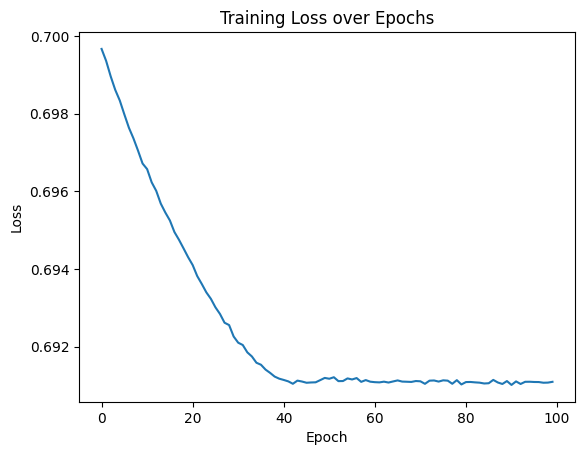

In [15]:
# Visualize the loss over epochs
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [19]:
# Save PyTorch model
torch.save(model.state_dict(), './TrainedModals/lstm_probablistic_2023.pth')


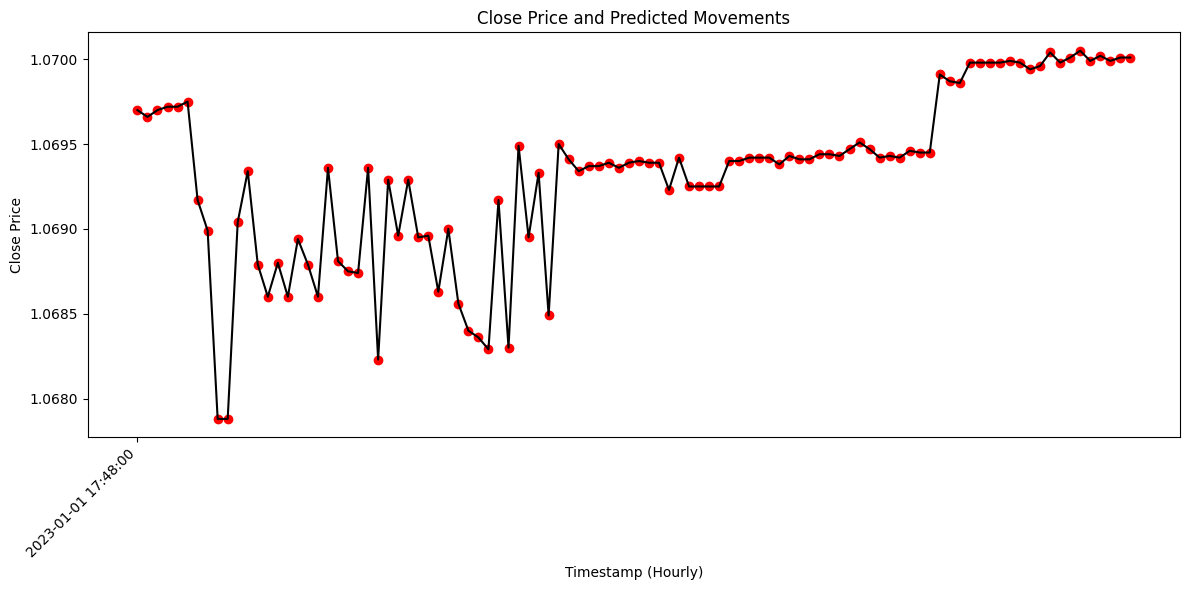

In [36]:
import matplotlib.pyplot as plt

# Select a subset of 1000 timestamps
subset_df = predictions_df.iloc[0:100]

# Plot close price
plt.figure(figsize=(12, 6))
plt.plot(subset_df['Timestamp'], data['close'][0:100], label='Close Price', color='black')

# Add dots to show predictions
for index, row in subset_df.iterrows():
    if row['Probability (Up)'] > 0.5:  # Upward movement
        plt.scatter(row['Timestamp'], data['close'][index], color='green', label='Predicted Up', zorder=1)
    else:  # Downward movement
        plt.scatter(row['Timestamp'], data['close'][index], color='red', label='Predicted Down', zorder=1)

plt.title('Close Price and Predicted Movements')
plt.xlabel('Timestamp (Hourly)')
plt.ylabel('Close Price')
plt.xticks(subset_df['Timestamp'][::100], rotation=45, ha='right')  # Show every 10th timestamp for better readability
plt.tight_layout()
plt.show()
